# 2 Exploratory Data Analysis 

#                       - Objectives - 
## a) explore features looking for correlation to target Mean Test score 
## b) create county average profiles using PCA

- PCA of 11th grade county average scores. 

- scatter avg housing 21 to score

- heat map of features, 




In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import warnings
warnings.filterwarnings('ignore')

## 2.1.1 Load joined data set 
- drop repreat columns
- clean up names of columns 

In [2]:
df = pd.read_csv('../../data/by_student_group/grocery_added.csv',low_memory=False)
df.drop(columns=['Unnamed: 0','National School Lunch Program [Public School] 2020-21',
                'County Name_y','District Name_y', 'School Name_y' ],inplace=True)
df.rename(columns ={'County Name_x':'County_Name','District Name_x':'District_Name',
                    'School Name_x':'School_Name',
'Total Students, All Grades (Excludes AE) [Public School] 2020-21':'Total_Students(No-AE)',
'Total Students, All Grades (Includes AE) [Public School] 2020-21':'Total_Students(With-AE)',
'Grades 1-8 Students [Public School] 2020-21':'1-8th_Students',
    'Pupil/Teacher Ratio [Public School] 2020-21':'Pupil/Teacher-Ratio',
       'Grades 9-12 Students [Public School] 2020-21':'9-12_Students',
        'Full-Time Equivalent (FTE) Teachers [Public School] 2020-21':'FTE_Teachers',
                    'Hispanic - male [Public School] 2020-21':'Hispanic_Male',
       'Hispanic - female [Public School] 2020-21':'Hispanic_Female',
       'Black or African American - male [Public School] 2020-21':'Black_or_AA_M',
       'Black or African American - female [Public School] 2020-21':'Black_or_AA_F',},inplace=True)
df.shape

(316683, 98)

## 2.2.1 Convert data types to numeric to be used in county averages

In [3]:
df[['Total_Students(No-AE)',
'Total_Students(With-AE)', '1-8th_Students', '9-12_Students',
'FTE_Teachers', 'Pupil/Teacher-Ratio', 'Hispanic_Male',
'Hispanic_Female', 'Black_or_AA_M', 
'Black_or_AA_F']] =df[['Total_Students(No-AE)',                  
'Total_Students(With-AE)', '1-8th_Students', '9-12_Students',
'FTE_Teachers', 'Pupil/Teacher-Ratio', 'Hispanic_Male',
'Hispanic_Female', 'Black_or_AA_M',
'Black_or_AA_F']].apply(pd.to_numeric,errors='coerce')

## 2.2.2 Generate county averages for key features for PCA analysis

In [4]:
dfc = df[df['Grade']==11][[ 'County_Name',
                           'Avg_21',# housing average price
                           'Mean Scale Score', # target column 
       'Percentage Standard Exceeded', 'Percentage Standard Met',
       'Percentage Standard Met and Above',
       'Percentage Standard Nearly Met', 'Percentage Standard Not Met',
            # free and reduced data
        'Enrollment', 'Free_Meal_count',
       'Percent_Eligible', 'FRPM_Count', 'Percent_Eligible_FRPM',
      'Free_Meal_Count', 'Percent_Eligible_Free', 
                           # geography
        'Latitude', 'Longitude',
                           # student numbers
        'Total_Students(No-AE)', 'Total_Students(With-AE)',
       '9-12_Students', 
       'Pupil/Teacher-Ratio', 'Hispanic_Male', 'Hispanic_Female',
       'Black_or_AA_M', 'Black_or_AA_F',
                           # teacher stats
                           'FTE_Teachers','Lowest Salary Offered',
       'Average Salary Paid', 'Highest Entry Level Step',
       'Highest Salary Offered',
                           # expense stats per district 
                           'EDP 365',
       'Current\nExpense ADA', 'Current\nExpense Per ADA',
                           # population 
        'Estimated Total Population', 'Estimated Population 5-17',
       'est_num_u17_pov', 
                           # yelp data
                           'Grocery_3mile', 'Grocery_dist'
                          ]]

# Data Overview
## Score distributions by grade

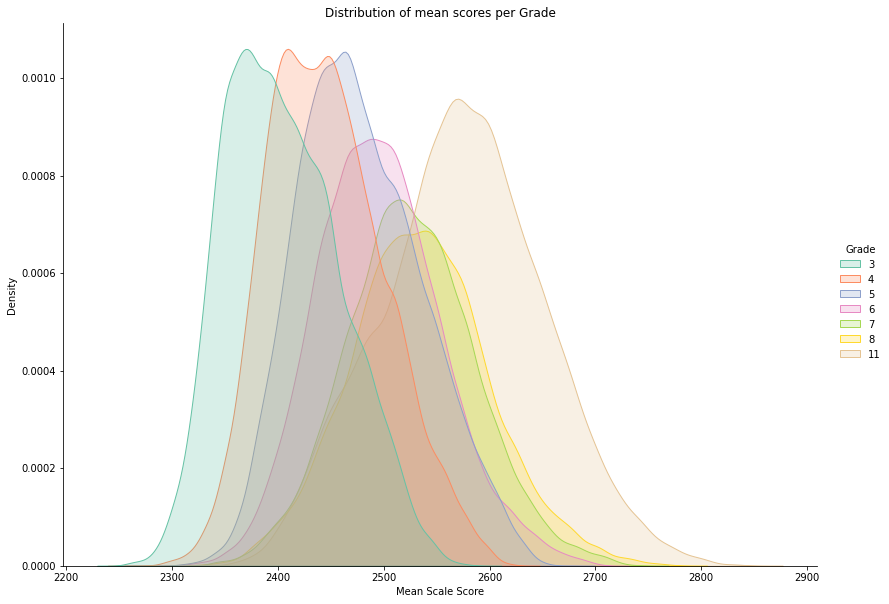

In [30]:
sns.displot(df,x="Mean Scale Score", hue="Grade", 
kind="kde",palette="Set2",height=8.27, aspect=11.7/8.27,
            fill=True).set(title='Distribution of mean scores per Grade')
plt.show()

## Insight - 
- The mean score for each grade increases by grade as expected. 
- there are more 3rd , 4th, 5th grade scores than middle school or high school scores.  
- 11th grade is the only high school grade with scores in the data set. 

# 2.3 County Averages

In [64]:
# create groupby 
county_avg=dfc.groupby('County_Name').agg('mean')

In [38]:
county_avg['Mean Scale Score'].sort_values(ascending=False).head()

County_Name
Santa Cruz     2631.624291
Santa Clara    2626.133450
Napa           2625.910870
Alameda        2611.283106
San Mateo      2611.015370
Name: Mean Scale Score, dtype: float64

In [39]:
county_avg['Mean Scale Score'].sort_values(ascending=True).head()

County_Name
Inyo         2503.366279
Tehama       2516.249573
Del Norte    2523.666234
Merced       2527.386439
Lake         2529.117857
Name: Mean Scale Score, dtype: float64

In [48]:
for i in county_avg.columns.values:
    county_avg[i]=county_avg[i].fillna(np.mean(county_avg[i]))

## 2.3.1 Quartile hue over housing price and score scatterplot  

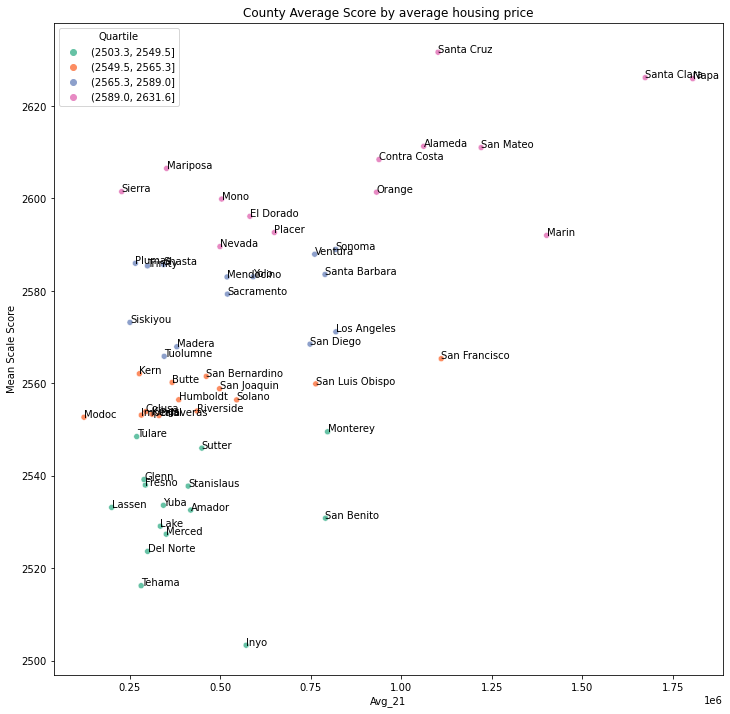

In [71]:
county_avg['Quartile']=pd.qcut(county_avg['Mean Scale Score'],q=4,precision=1)
p = county_avg.index
x = county_avg['Avg_21']
y = county_avg['Mean Scale Score']
plt.subplots(figsize=(12, 12))
sns.scatterplot(data=county_avg,x=x,y=y,hue = 'Quartile', palette='Set2' )
plt.title('County Average Score by average housing price')


for p, x, y in zip(p, x, y):
     plt.annotate(p, (x, y))       
plt.show()

### Insight
- Linear relationship between average housing price and mean scale score can be seen. 

In [72]:
# save group by for graphing 
county_avg.to_csv('../../data/by_student_group/county_averages.csv')

## 2.3.2 Use Principal Component analysis to show relationships between county averages

In [53]:
c_avg_scale = county_avg.copy()
# save cols and index
summary_index = county_avg.index
summary_cols= county_avg.columns
c_avg_scale = scale(c_avg_scale)
c_avg_df= pd.DataFrame(c_avg_scale,columns=summary_cols)
# check center
print(c_avg_df.mean()[:3])
print(c_avg_df.std(ddof=0)[:3])

Avg_21                          3.505967e-17
Mean Scale Score               -3.505967e-17
Percentage Standard Exceeded   -2.337312e-17
dtype: float64
Avg_21                          1.0
Mean Scale Score                1.0
Percentage Standard Exceeded    1.0
dtype: float64


In [57]:
## fill to allow for PCA to run
for i in c_avg_df.columns.values:
    c_avg_df[i]=c_avg_df[i].fillna(np.mean)
# fit data 
c_pca = PCA().fit(c_avg_scale)

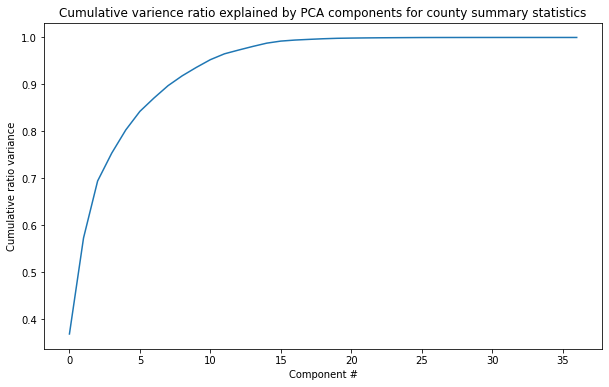

In [58]:
plt.subplots(figsize=(10, 6))
plt.plot(c_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative varience ratio explained by PCA components for county summary statistics')
plt.show()

In [82]:
c_pca_x =c_pca.transform(c_avg_scale)

pca_df = pd.DataFrame({'PC1':c_pca_x[:,0],'PC2':c_pca_x[:,1],
                       'County_avg_MS_Score':county_avg['Mean Scale Score']},index=summary_index)
pca_df['Quartile']=pd.qcut(pca_df['County_avg_MS_Score'],q=4,precision=1)


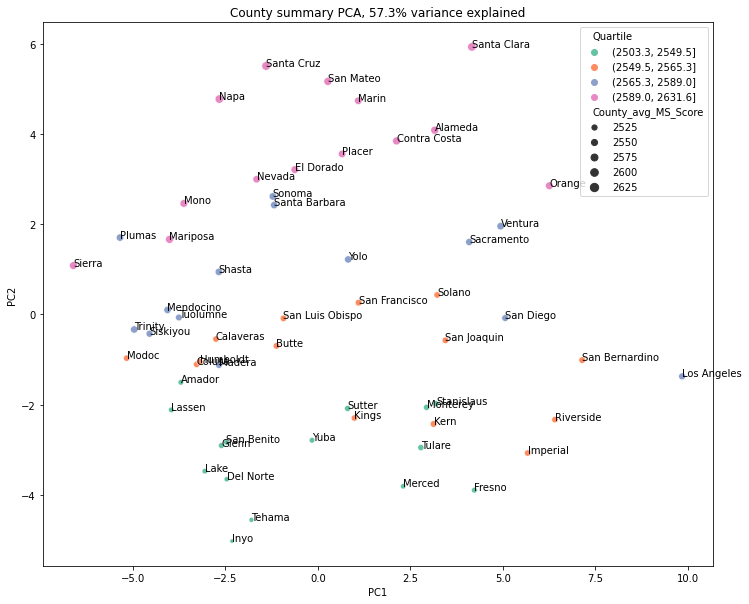

In [66]:
x = pca_df.PC1
y = pca_df.PC2
county = pca_df.index
pc_var=100*c_pca.explained_variance_ratio_.cumsum()[1]
plt.subplots(figsize=(12, 10))
# Note the argument below to make sure we get the colours in the ascending
# order we intuitively expect!
sns.scatterplot(x=x, y=y, size=pca_df['County_avg_MS_Score'], hue=pca_df['Quartile'], palette='Set2',
                hue_order=pca_df.Quartile.cat.categories, data=pca_df)
#and we can still annotate with the state labels
for s, x, y in zip(county, x, y):
    plt.annotate(s, (x, y))   
plt.title(f'County summary PCA, {pc_var:.1f}% variance explained')
plt.show()

## 2.3.2 Insight

- With just over 50 % of the variation amongst the features in the state average data represented in the scatter of the first two principal components, there appears to be 4 distinct groups of counties. 
- Smaller rural counties are lower and to the left while urban or affluent counties are at the top and towards the right. 
- Sierra county is the fartherst to the left of the first princical component while los Angeles county is the furthest to the right.

# 2.4 Explore Categotical Features

## objective - understand distributions of key features. 
- avg housing price 
- student groups by economic statuts
- student groups by demographic 
- Parent education
- Teacher Salary 

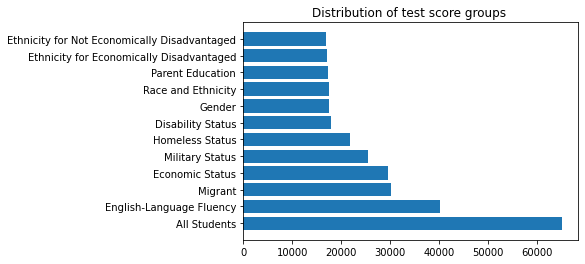

In [20]:
plt.barh(df['Student Group'].unique().tolist(),df['Student Group'].value_counts())
plt.title('Distribution of Test Score Groups ')
plt.show()

- 'All Student' average score for each school site has over 6,000 scores, 3 times as many as half of the other groups who have just less than 2000 scores.  

## 2.4.1 'Race and Ethnicity' group scores against average housing price 

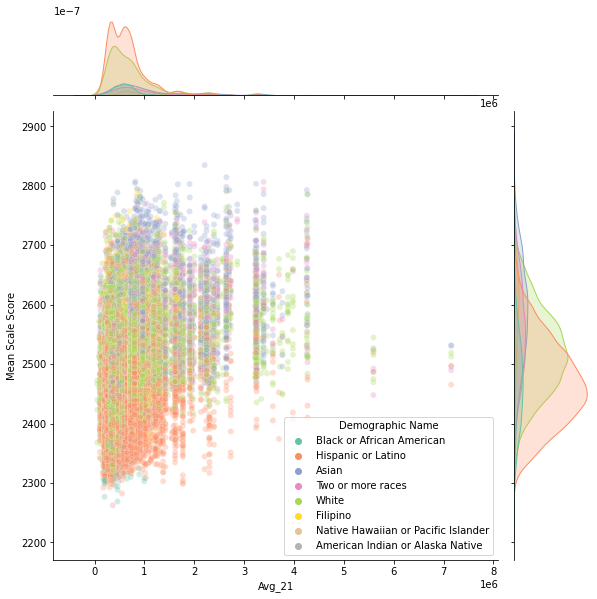

In [83]:
dfs = df[df['Student Group']=='Race and Ethnicity']
sns.jointplot(x= 'Avg_21', y='Mean Scale Score', hue='Demographic Name',palette="Set2",height=8.27,data=dfs, alpha = 0.3)
plt.show()

## Insight - 
- Many Asain identifying students groups have the highest scores across avearge housing price.
- Many of the red Hispanic or Latino identifiying student group scores are at the bottom end of scores across average housing price.

## 2.4.2 Mean Scores by Ethinicity 

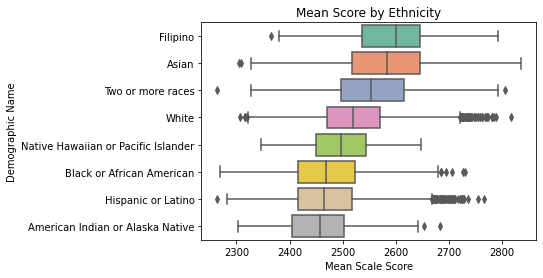

In [156]:
dfs = df[df['Student Group']=='Race and Ethnicity']
order = dfs.groupby( "Demographic Name")['Mean Scale Score'].mean().sort_values(ascending=False).index
ax = sns.boxplot(x="Mean Scale Score", y="Demographic Name",orient='h',order=order, palette="Set2", data=dfs).set(title='Mean Score by Ethnicity')


## 2.4.3 Box Plot of Economic Status 

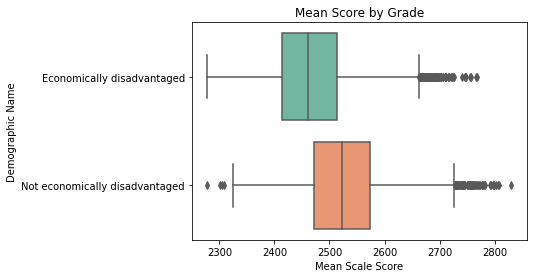

In [55]:
dfs = df[df['Student Group']=='Economic Status']

ax = sns.boxplot(x="Mean Scale Score", y="Demographic Name",orient='h', palette="Set2", data=dfs).set(title='Mean Score by Grade')


### Economically Disadvantaged 

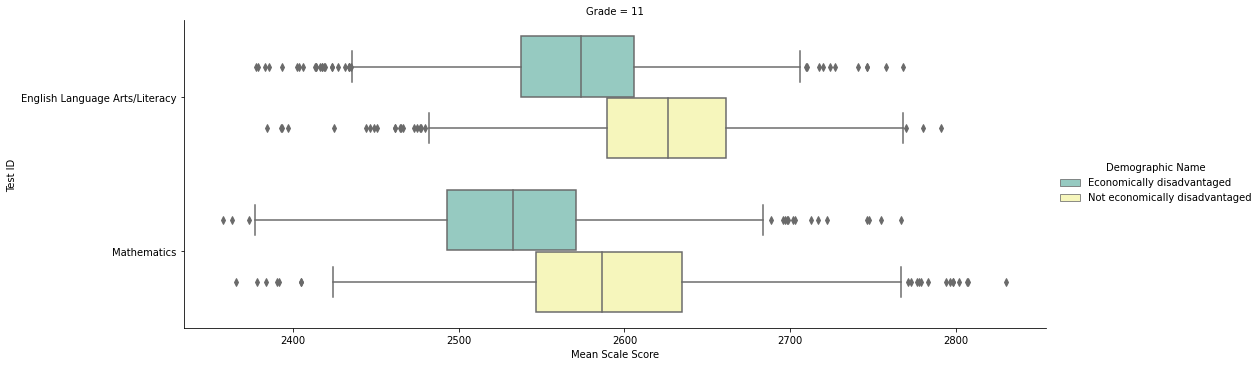

In [75]:
dfs = df[df['Grade']==11][df['Student Group']=='Economic Status']
g = sns.catplot(y="Test ID", x="Mean Scale Score",
                hue="Demographic Name", col='Grade',data=dfs, kind="box",col_wrap=1,orient="h", height=5, aspect=3,palette='Set3')

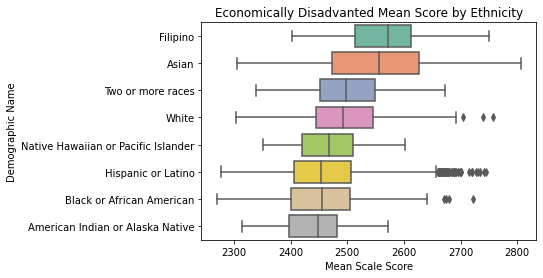

In [121]:
dfs = df[df['Student Group']=='Ethnicity for Economically Disadvantaged']
order = dfs.groupby( "Demographic Name")['Mean Scale Score'].mean().sort_values(ascending=False).index
ax = sns.boxplot(x="Mean Scale Score", y="Demographic Name",order=order,orient='h', palette="Set2", data=dfs).set(title='Economically Disadvanted Mean Score by Ethnicity')



### Economically NOT Disadvantaged 

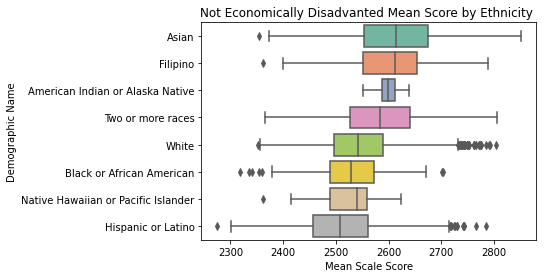

In [157]:
dfs = df[df['Student Group']=='Ethnicity for Not Economically Disadvantaged']
order = dfs.groupby( "Demographic Name")['Mean Scale Score'].mean().sort_values(ascending=False).index
ax = sns.boxplot(x="Mean Scale Score", y="Demographic Name",order=order,orient='h', palette="Set2", data=dfs).set(title='Not Economically Disadvanted Mean Score by Ethnicity ')

## Insight
- mean score for all demographic groups lower in disadvantaged students 

## 2.4.4 English-Language Fluency Score Distributions

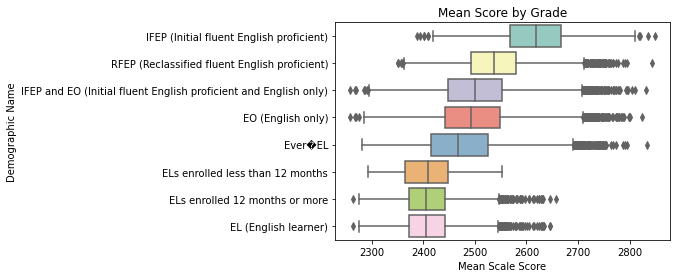

In [168]:
dfs = df[df['Student Group']=='English-Language Fluency']
order = dfs.groupby( "Demographic Name")['Mean Scale Score'].mean().sort_values(ascending=False).index
ax = sns.boxplot(x="Mean Scale Score", y="Demographic Name",order=order,orient='h', palette="Set3", data=dfs).set(title='Mean Score by Grade')


## 2.4.5 Student Scores by Gender 

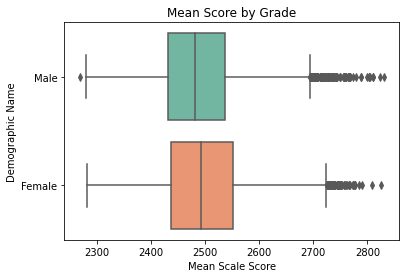

In [54]:
dfs = df[df['Student Group']=='Gender']

ax = sns.boxplot(x="Mean Scale Score", y="Demographic Name",orient='h', palette="Set2", data=dfs).set(title='Mean Score by Grade')


## 2.5 Student Scores by Parent Education

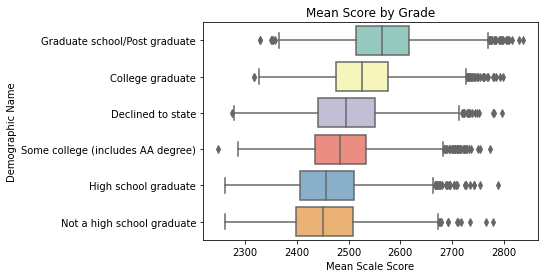

In [129]:
dfs = df[df['Student Group']=='Parent Education']
order = dfs.groupby( "Demographic Name")['Mean Scale Score'].mean().sort_values(ascending=False).index
ax = sns.boxplot(x="Mean Scale Score", y="Demographic Name",orient='h', order=order,palette="Set3", data=dfs).set(title='Mean Score by Grade')


## 2.5.1 Jointplot of Teacher Salary by Scores 

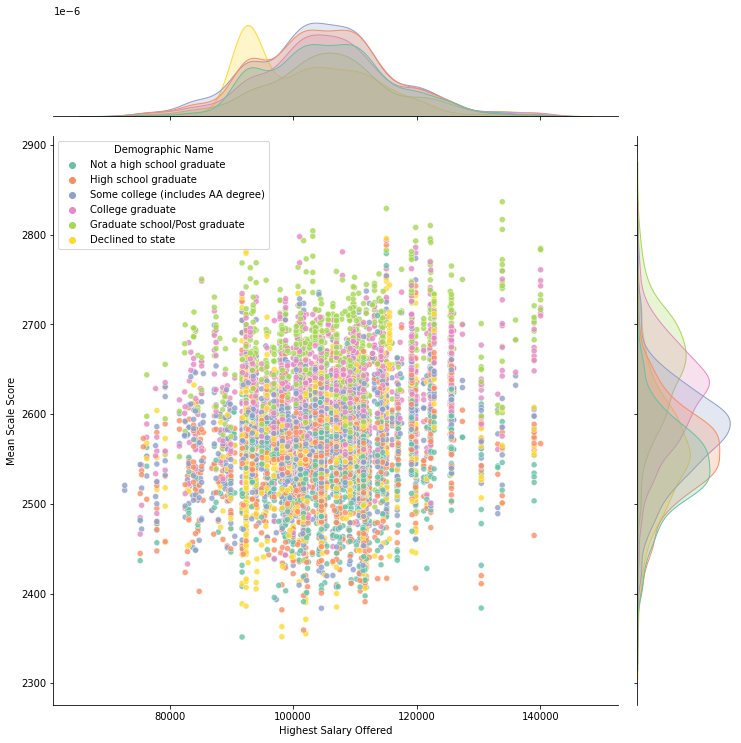

In [80]:
df3 = df[(df['Grade']>8)&(df['Student Group']=='Parent Education')]

sns.jointplot(x= 'Highest Salary Offered', y='Mean Scale Score', hue='Demographic Name',palette="Set2",data=df3,height=10.27, alpha = 0.8)
plt.show()

## Insight 
- The Highest paid teachers are at school districts where parents have higher education degrees as seen by the green and pink clusters or scores at the top of the chart.
- Both parent education and teacher salary seem to have a relationship with student scores. 